# NBA Dataset - Sistemas Basados en el Conocimiento

In [1]:
#Librerías

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans 
from scipy.cluster import hierarchy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering 


In [2]:
#Carga de Datos

nba_data = pd.read_csv("all_seasons.csv")
nba_data.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


# Procesado Inicial

Para empezar, vamos a dedicarnos a tratar los datos. Antes de todo querremos limpiarlos, solucionando así problemas que pueden surgir en función del tipo de datos que tengamos o de como estén distribuidos y luego nos encargaremos de explorarlos y entenderlos mejor para ver que es lo más interesante a explorar.

In [3]:
#Valores nulos nba_data

count_null = nba_data.isnull().sum()
print(count_null)

Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
dtype: int64


**Valores Nulos**

Para empezar, vamos a eliminar las columnas categóricas que no aportan demasiada información. Una de ellas es college, que tiene bastantes valores nulos:

Esto se debe a que no todos los jugadores que llegan a la NBA tienen un previo paso por universidades, de hecho, la mayoría de los no americanos, llegan a la liga desde ligas profesionales y sin previo paso por la universidad. Ahora empieza a darse la situación que también jugadores americanos no van a la universidad y juegan en una liga semiprofesional americana llamada NBA G League Ignite, donde forman a jóvenes talentos. Además, la normativa sobre la edad mínima ha ido cambiando, Kobe Bryant fue directamente desde el instituto a la NBA porque en su época estaba permitido. Otro ejemplo de jugador que no ha pasado por la universidad es Luka Doncic, de los mejores jugadores de la liga y que viene directamente del Real Madrid.

Sabiendo esto, y teniendo en cuenta que lo último que queremos hacer es eliminar jugadores que pueden tener mucho valor, creo que lo que tiene más sentido es eliminar la columna de college.

**Otras variables Categóricas**

Luego tenemos la variable name, que no nos hará falta, de momento, no queremos analizar las estadísticas de ningún jugador en concreto y, por otro lado, la variable 'country'. El país tampoco nos dará demasiada información de cara al estudio que queremos hacer, y menos, viendo como nos dan los datos de país, siendo todos de tipo texto. Años atrás la NBA era una liga principalmente americana, donde los internacionales eran 'rara avis' pero vamos a analizar sobre todo datos de los últimos años donde la cantidad de jugadores internacionales ha aumentado muchísimo y su importancia en la liga también, 4 de los últimos 5 MVPs no son americanos. Así que, bajo mi punto de vista, no tiene demasiado sentido tener en cuenta esta información.

Tampoco hace falta la variable unnamed, que son etiquetas numéricas de cada jugador que no aportan información.

Por último, tenemos el 'team_abbreviation', que nos da información sobre el equipo en el que juega ese jugador. Siempre se dice que la NBA es una de las ligas más igualadas del mundo gracias a su sistema de draft, los últimos, reciben a los mejores jugadores jóvenes, y de esta manera se busca equilibrar la liga, así que creo que a la larga tus estadísticas de juego no deberían depender en exceso de en que equipo juegues.

In [4]:
delete = ['player_name','college', 'country','team_abbreviation','Unnamed: 0']
nba_clean = nba_data.drop(columns = delete)
nba_clean.head()

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,22.0,193.04,94.800728,1996,2,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,28.0,190.50,86.182480,1994,2,34,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,26.0,203.20,103.418976,1993,1,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,30.0,203.20,102.058200,1989,1,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,23.0,213.36,119.748288,1995,1,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


También hará falta tratar los datos de las columnas 'draft_year', 'draft_round', 'draft_number' y 'season', ya que en las 3 primeras existen datos de tipo texto y en la última tenemos las temporadas también con un carácter que nos puede traer problemas (-).

Empezando con los datos de la columna season, lo que haremos es transformarlos a 'integers' después de eliminar todos excepto los últimos tres caracteres. De esta manera nos quedará el año en el que la temporada acabó, y tendremos que ser conscientes de ello cuando analicemos los datos.

La temporada 2020-21 ahora es la temporada 21.

In [5]:
nba_clean['season'] = nba_clean['season'].str[-2:].astype(int)
nba_clean.head()

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,22.0,193.04,94.800728,1996,2,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,97
1,28.0,190.50,86.182480,1994,2,34,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,97
2,26.0,203.20,103.418976,1993,1,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,97
3,30.0,203.20,102.058200,1989,1,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,97
4,23.0,213.36,119.748288,1995,1,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,97


Analizando los datos de los undrafted, vemos que aunque los años tienen algunos valores, tanto la ronda como los números son todos iguales, y tenemos, 2414 valores.

Visto esto, vamos a tratar a todos los jugadores que no han sido drafteados como jugadores que son de tercera ronda (en la NBA, el draft solo tiene dos rondas) y vamos a decir que su número del draft va a ser igual a 61 (cada ronda tiene 30 jugadores, es decir, cada año el draft lo forman 60), de esta manera les asignaremos un valor numérico que los colocará por debajo de los que si han sido drafteados y no hará diferencia entre ellos.

In [6]:
nba_clean[nba_clean['draft_number'] == 'Undrafted']

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
25,29.0,193.04,86.182480,1992,Undrafted,Undrafted,71,5.7,1.6,1.3,-0.3,0.036,0.076,0.172,0.539,0.141,97
29,28.0,195.58,87.996848,Undrafted,Undrafted,Undrafted,13,5.0,1.7,2.0,6.6,0.011,0.098,0.144,0.565,0.191,97
39,23.0,190.50,95.254320,Undrafted,Undrafted,Undrafted,28,10.6,3.2,2.4,-6.4,0.032,0.112,0.216,0.510,0.161,97
41,27.0,200.66,106.594120,Undrafted,Undrafted,Undrafted,5,2.6,0.6,0.4,17.5,0.026,0.049,0.192,0.388,0.065,97
46,31.0,203.20,99.790240,Undrafted,Undrafted,Undrafted,53,6.7,1.5,0.4,1.2,0.034,0.067,0.171,0.555,0.036,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,25.0,215.90,108.862080,Undrafted,Undrafted,Undrafted,7,7.3,3.0,1.4,-1.1,0.060,0.153,0.155,0.796,0.135,23
12835,27.0,210.82,115.665960,Undrafted,Undrafted,Undrafted,69,6.6,4.1,1.0,7.9,0.114,0.164,0.182,0.595,0.101,23
12837,35.0,205.74,99.790240,Undrafted,Undrafted,Undrafted,46,6.9,2.8,3.3,2.5,0.012,0.102,0.122,0.616,0.181,23
12840,20.0,213.36,86.182480,Undrafted,Undrafted,Undrafted,19,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,23


In [7]:
nba_clean[nba_clean['draft_year'] == 'Undrafted']

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
29,28.0,195.58,87.996848,Undrafted,Undrafted,Undrafted,13,5.0,1.7,2.0,6.6,0.011,0.098,0.144,0.565,0.191,97
39,23.0,190.50,95.254320,Undrafted,Undrafted,Undrafted,28,10.6,3.2,2.4,-6.4,0.032,0.112,0.216,0.510,0.161,97
41,27.0,200.66,106.594120,Undrafted,Undrafted,Undrafted,5,2.6,0.6,0.4,17.5,0.026,0.049,0.192,0.388,0.065,97
46,31.0,203.20,99.790240,Undrafted,Undrafted,Undrafted,53,6.7,1.5,0.4,1.2,0.034,0.067,0.171,0.555,0.036,97
54,27.0,208.28,120.201880,Undrafted,Undrafted,Undrafted,4,1.3,1.0,0.0,-17.7,0.000,0.211,0.103,0.727,0.000,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,25.0,215.90,108.862080,Undrafted,Undrafted,Undrafted,7,7.3,3.0,1.4,-1.1,0.060,0.153,0.155,0.796,0.135,23
12835,27.0,210.82,115.665960,Undrafted,Undrafted,Undrafted,69,6.6,4.1,1.0,7.9,0.114,0.164,0.182,0.595,0.101,23
12837,35.0,205.74,99.790240,Undrafted,Undrafted,Undrafted,46,6.9,2.8,3.3,2.5,0.012,0.102,0.122,0.616,0.181,23
12840,20.0,213.36,86.182480,Undrafted,Undrafted,Undrafted,19,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,23


In [8]:
nba_clean[nba_clean['draft_round'] == 'Undrafted']

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
25,29.0,193.04,86.182480,1992,Undrafted,Undrafted,71,5.7,1.6,1.3,-0.3,0.036,0.076,0.172,0.539,0.141,97
29,28.0,195.58,87.996848,Undrafted,Undrafted,Undrafted,13,5.0,1.7,2.0,6.6,0.011,0.098,0.144,0.565,0.191,97
39,23.0,190.50,95.254320,Undrafted,Undrafted,Undrafted,28,10.6,3.2,2.4,-6.4,0.032,0.112,0.216,0.510,0.161,97
41,27.0,200.66,106.594120,Undrafted,Undrafted,Undrafted,5,2.6,0.6,0.4,17.5,0.026,0.049,0.192,0.388,0.065,97
46,31.0,203.20,99.790240,Undrafted,Undrafted,Undrafted,53,6.7,1.5,0.4,1.2,0.034,0.067,0.171,0.555,0.036,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,25.0,215.90,108.862080,Undrafted,Undrafted,Undrafted,7,7.3,3.0,1.4,-1.1,0.060,0.153,0.155,0.796,0.135,23
12835,27.0,210.82,115.665960,Undrafted,Undrafted,Undrafted,69,6.6,4.1,1.0,7.9,0.114,0.164,0.182,0.595,0.101,23
12837,35.0,205.74,99.790240,Undrafted,Undrafted,Undrafted,46,6.9,2.8,3.3,2.5,0.012,0.102,0.122,0.616,0.181,23
12840,20.0,213.36,86.182480,Undrafted,Undrafted,Undrafted,19,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,23


In [9]:
nba_clean['draft_round'].replace('Undrafted', 3, inplace = True)
nba_clean['draft_number'].replace('Undrafted', 61, inplace = True)
nba_clean[nba_clean['draft_number'] == 61]

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
25,29.0,193.04,86.182480,1992,3,61,71,5.7,1.6,1.3,-0.3,0.036,0.076,0.172,0.539,0.141,97
29,28.0,195.58,87.996848,Undrafted,3,61,13,5.0,1.7,2.0,6.6,0.011,0.098,0.144,0.565,0.191,97
39,23.0,190.50,95.254320,Undrafted,3,61,28,10.6,3.2,2.4,-6.4,0.032,0.112,0.216,0.510,0.161,97
41,27.0,200.66,106.594120,Undrafted,3,61,5,2.6,0.6,0.4,17.5,0.026,0.049,0.192,0.388,0.065,97
46,31.0,203.20,99.790240,Undrafted,3,61,53,6.7,1.5,0.4,1.2,0.034,0.067,0.171,0.555,0.036,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,25.0,215.90,108.862080,Undrafted,3,61,7,7.3,3.0,1.4,-1.1,0.060,0.153,0.155,0.796,0.135,23
12835,27.0,210.82,115.665960,Undrafted,3,61,69,6.6,4.1,1.0,7.9,0.114,0.164,0.182,0.595,0.101,23
12837,35.0,205.74,99.790240,Undrafted,3,61,46,6.9,2.8,3.3,2.5,0.012,0.102,0.122,0.616,0.181,23
12840,20.0,213.36,86.182480,Undrafted,3,61,19,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,23


Y por último, he tomado la decisión de también eliminar la columna de draft_year, creo que es una información un poco repetida porque también la tenemos dentro de la columna season, ya que su draft year es la primera temporada que juegan en la liga y, teniendo en cuenta los problemas que nos pueden dar sus transformaciones, creo que merece la pena eliminarla.

In [10]:
delete1 = ['draft_year']
nba_cleanest = nba_clean.drop(columns = delete1)
nba_cleanest.head()

,age,player_height,player_weight,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,22.0,193.04,94.800728,2,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,97
1,28.0,190.50,86.182480,2,34,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,97
2,26.0,203.20,103.418976,1,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,97
3,30.0,203.20,102.058200,1,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,97
4,23.0,213.36,119.748288,1,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,97


Una vez tenemos los datos un poco más limpios, he decidido empezar centrándome en la temporada 2017-2018. Después de una evolución del juego muy marcada en los 5 años previos por culpa de la revolución que supuso la forma de jugar de la última gran dinastía del deporte americano, los Golden State Warriors, la temporada 2017-18 se considera como la última y más estable de ese equipo y del conjunto de la liga. Su superioridad fue aplastante y, durante esos años, muchos equipos viraron su juego hacia un modelo similar al de los grandes campeones.

Además, fue la cuarta seguida con las mismas finales de la NBA (Cleveland Cavaliers vs Golden State Warriors), que también denota cierta estabilización en las jerarquías de la liga.

In [11]:
nba_2018 = nba_cleanest[nba_cleanest['season'] == 18]
nba_2018.head()

,age,player_height,player_weight,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9561,30.0,208.28,115.665960,1,16,52,7.7,2.6,0.8,1.6,0.030,0.152,0.265,0.539,0.104,18
9562,20.0,208.28,108.862080,1,8,72,7.7,5.5,1.2,-8.4,0.046,0.200,0.176,0.509,0.081,18
9563,28.0,208.28,111.130040,1,13,73,11.5,5.6,1.9,0.7,0.040,0.173,0.194,0.566,0.107,18
9564,25.0,187.96,85.728888,1,29,3,3.7,2.0,4.3,-19.7,0.012,0.072,0.121,0.302,0.241,18
9565,25.0,213.36,113.398000,3,61,8,1.8,2.1,0.3,1.5,0.074,0.245,0.111,0.697,0.063,18


Una vez nos hemos quedado únicamente con variables numéricas, merece la pena normalizarlas todas, ya que estamos tratando datos que tienen unidades muy distintas y esto nos podría afectar a la hora de hacer nuestros modelos. No es lo mismo hablar de puntos por partidos que de porcentaje de asistencias repartidas.

In [12]:
# Tambien vamos a normalizar las varaibles para que todo este dentro de unos mismos rangos

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

standarizacion = ['age','player_height','player_weight','draft_round','draft_number','gp','pts','reb','ast','net_rating']
nba_2018[standarizacion] = scaler.fit_transform(nba_2018[standarizacion])

nba_2018.head()

C:\Users\Marc\AppData\Local\Temp\ipykernel_3312\3046696159.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_2018[standarizacion] = scaler.fit_transform(nba_2018[standarizacion])


,age,player_height,player_weight,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9561,0.830348,0.911843,1.482406,-0.860569,-0.737429,0.133189,-0.077642,-0.321560,-0.592060,0.212619,0.030,0.152,0.265,0.539,0.104,18
9562,-1.558506,0.911843,0.883977,-0.860569,-1.108809,0.862252,-0.077642,0.877685,-0.359330,-0.338313,0.046,0.200,0.176,0.509,0.081,18
9563,0.352577,0.911843,1.083453,-0.860569,-0.876697,0.898705,0.563233,0.919039,0.047947,0.163035,0.040,0.173,0.194,0.566,0.107,18
9564,-0.364079,-1.456865,-1.150684,-0.860569,-0.133937,-1.653015,-0.752248,-0.569680,1.444324,-0.960867,0.012,0.072,0.121,0.302,0.241,18
9565,-0.364079,1.504020,1.282930,1.522545,1.351581,-1.470749,-1.072685,-0.528327,-0.882972,0.207110,0.074,0.245,0.111,0.697,0.063,18


# Variable Objetivo: True Shooting

Variable Objetivo:

La variable objetivo es aquella que vamos a analizar para ver si hay separabilidad o no entre los jugadores. En este caso, he decidido estudiar esto de la variable True Shooting. Es una variable que acostumbra a definir muy bien a los jugadores, ya que estudia la calidad de sus porcentajes de tiro, diferenciando entre jugadores eficientes y jugadores ineficientes con su tiro. Se ven grandes diferencias de eficiencia entre los jugadores que juegan cerca del aro y los que no lo hacen, ya que los que juegan cerca del aro acostumbran a tener unos números mucho mejores en los tiros, no necesariamente en el valor total de puntos, ya que, de media, sus tiros son bastante más fáciles.

La fórmula para calcular el True Shooting Percentatge es la siguiente:

TS% = (PTS / (2×(FGA+0.44×FTA))) × 100

Donde:
- PTS es el total de puntos
- FGA son los tiros de campo totales
- FTA son los tiros libres totales

Aquí podemos ver un poco de la distribución de esta variable, nótese que los valores pueden oscilar entre 0 y 1.5, pero hay que tener en cuenta que la mayoría de los valores estarán comprendidos entre los valores de 0,4 y 0,6 como se ve en el histograma.

In [13]:
nba_2018['ts_pct'].describe()

count    540.000000
mean       0.529011
std        0.130331
min        0.000000
25%        0.499750
50%        0.541000
75%        0.581250
max        1.500000
Name: ts_pct, dtype: float64

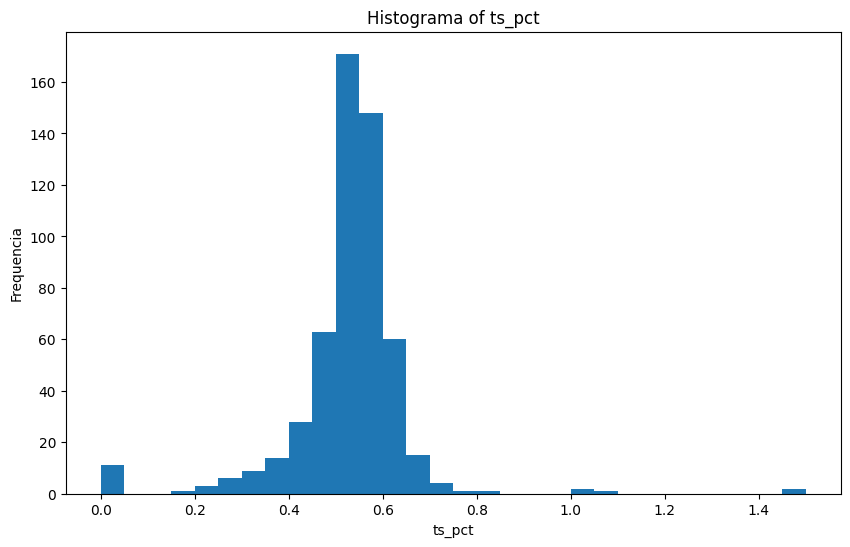

In [14]:
ts_pct_data = nba_2018['ts_pct']

plt.figure(figsize=(10, 6))
plt.hist(ts_pct_data, bins=30) 
plt.title('Histograma of ts_pct')
plt.xlabel('ts_pct')
plt.ylabel('Frequencia')
plt.show()


In [15]:
Gobert = nba_data[(nba_data['player_name'] == 'Rudy Gobert')]
Gobert['ts_pct'].mean()

0.6525000000000001

In [16]:
Rubio = nba_data[(nba_data['player_name'] == 'Ricky Rubio')]
Rubio['ts_pct'].mean()

0.5005833333333333

En el ejemplo de estos dos jugadores se ven claras las diferencias entre un jugador i otro. Por un lado, estamos hablando de un pívot clásico con muy poco tiro exterior y poco dotado técnicamente, por otro, de un jugador como Ricky Rubio, base a la antigua usanza, que sin la necesidad de asumir una gran cantidad de tiros era capaz de hacer jugar muy bien a su equipo.

Gobert saca el máximo provecho de sus lanzamientos (pese a penalizarle mucho sus porcentajes en tiros libres), ya que la mayoría de ellos son lanzamientos muy cercanos al aro y que, con su superioridad física, son sencillos. En cambio, Ricky es menos eficiente en sus tiros, en parte por la diferencia de dificultad entre sus tiros y los de un pivot.

# Exploración de los datos

Una vez hemos limpiado los datos y seleccionado una variable que queremos estudiar, vamos a seguir analizando los datos e intentando comprender como se comportan en diferentes situaciones, para, proceder a la creación de modelos con el mayor conocimiento de estos posible.

In [17]:
nba_2018.head()

,age,player_height,player_weight,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9561,0.830348,0.911843,1.482406,-0.860569,-0.737429,0.133189,-0.077642,-0.321560,-0.592060,0.212619,0.030,0.152,0.265,0.539,0.104,18
9562,-1.558506,0.911843,0.883977,-0.860569,-1.108809,0.862252,-0.077642,0.877685,-0.359330,-0.338313,0.046,0.200,0.176,0.509,0.081,18
9563,0.352577,0.911843,1.083453,-0.860569,-0.876697,0.898705,0.563233,0.919039,0.047947,0.163035,0.040,0.173,0.194,0.566,0.107,18
9564,-0.364079,-1.456865,-1.150684,-0.860569,-0.133937,-1.653015,-0.752248,-0.569680,1.444324,-0.960867,0.012,0.072,0.121,0.302,0.241,18
9565,-0.364079,1.504020,1.282930,1.522545,1.351581,-1.470749,-1.072685,-0.528327,-0.882972,0.207110,0.074,0.245,0.111,0.697,0.063,18


<Axes: >

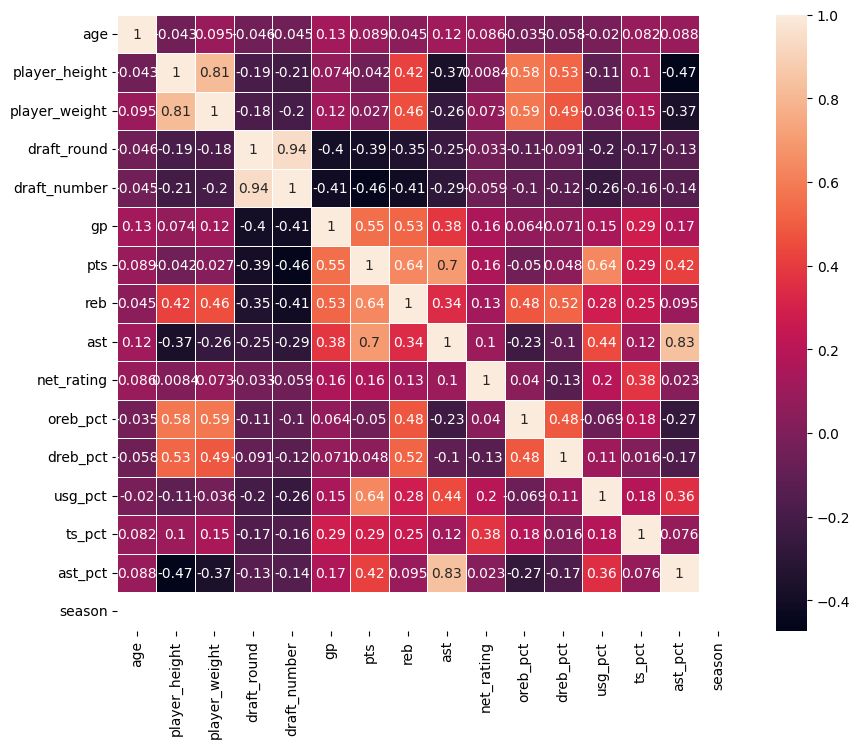

In [18]:
#Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(nba_2018.corr(), annot = True, linewidths=0.5)

Después de analizar los datos numéricos, es fácil darte cuenta de que todas las variables con porcentajes del final del data set están muy estrechamente relacionadas con las estadísticas básicas como partidos jugados, puntos, rebotes y asistencias. Visto esto, merece la pena evaluar cuáles de las dos nos interesan más, ya que probablemente, si nos quedamos con ambos, estaremos añadiendo ruido a nuestro modelo, amplificando tendencias y, sobre todo, tendremos variables que nos dan información similar.

Teniendo en cuenta que, bajo mi punto de vista, la estadística avanzada es el futuro de los deportes y que sus fórmulas están pensadas para maximizar la información que nos dan los datos 'crudos' de puntos, rebotes y asistencias, creo que merece la pena quedarnos con los porcentajes.

Por otro lado, también vemos, como es lógico, que la altura y peso de los jugadores tienen una afectación importante en sus estadísticas y la verdad es que el modelo que queremos crear queremos que sea basado especialmente en sus estadísticas puras, sin influencias externas como pueden ser sus características físicas, que vemos que tienen mucha incidencia.

Por último, tampoco veo que la variable edad nos pueda dar demasiada información, hay un tópico que dice que los jugadores de la NBA son tan buenos como parecen ser en su tercera temporada, así que aunque eliminando la edad podemos perder algo de información en los jóvenes, la mayoría de los jugadores estabilizan sus números y, estos no se ven demasiado afectados por la edad.

In [19]:
delete2 = ['gp','pts','reb','ast', 'player_weight', 'player_height', 'age']
nba_2018 = nba_2018.drop(columns = delete2)
nba_2018.head()

,draft_round,draft_number,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9561,-0.860569,-0.737429,0.212619,0.030,0.152,0.265,0.539,0.104,18
9562,-0.860569,-1.108809,-0.338313,0.046,0.200,0.176,0.509,0.081,18
9563,-0.860569,-0.876697,0.163035,0.040,0.173,0.194,0.566,0.107,18
9564,-0.860569,-0.133937,-0.960867,0.012,0.072,0.121,0.302,0.241,18
9565,1.522545,1.351581,0.207110,0.074,0.245,0.111,0.697,0.063,18


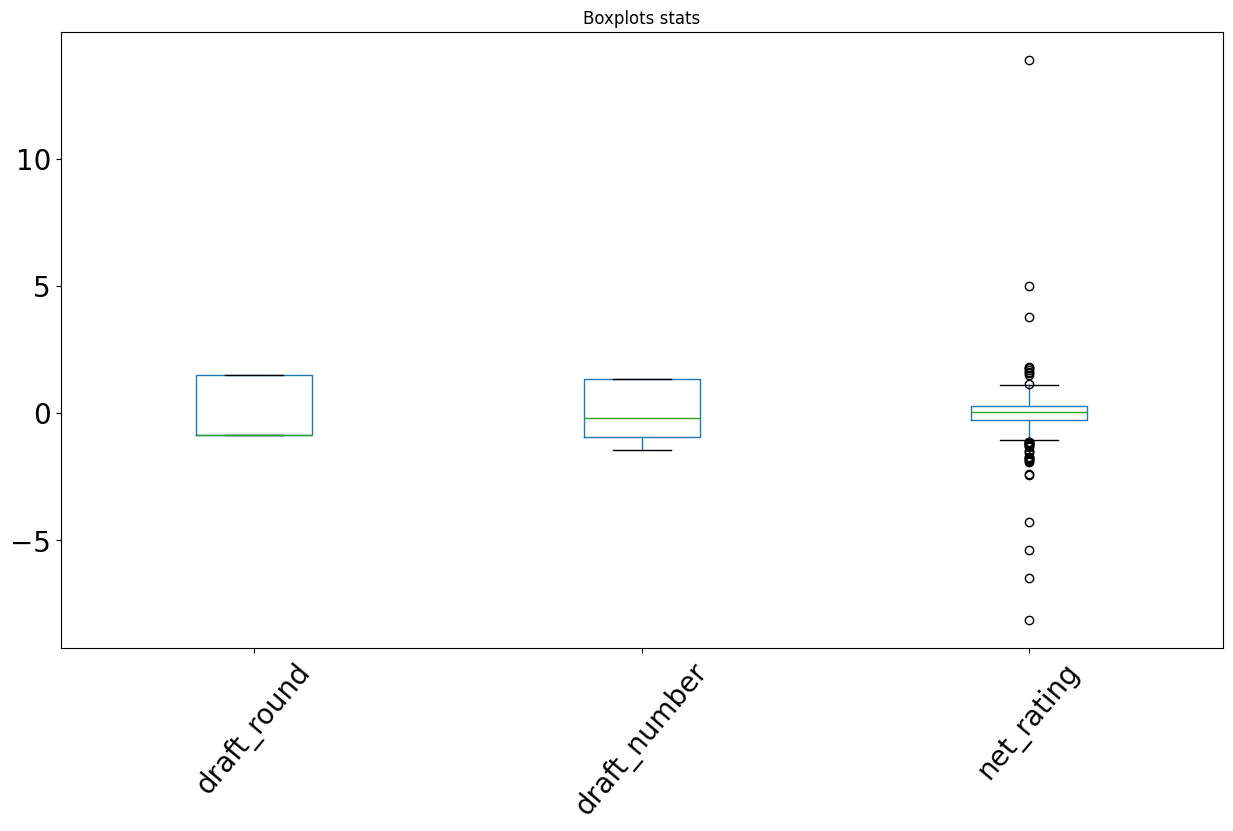

In [20]:
column_names = nba_2018.columns.tolist()
boxplot = column_names[:-6] 
subset_data = nba_2018[boxplot]

plt.figure(figsize=(15, 8))
plt.title('Boxplots stats')
subset_data.boxplot(grid=False, rot=50, fontsize=20)
plt.show()

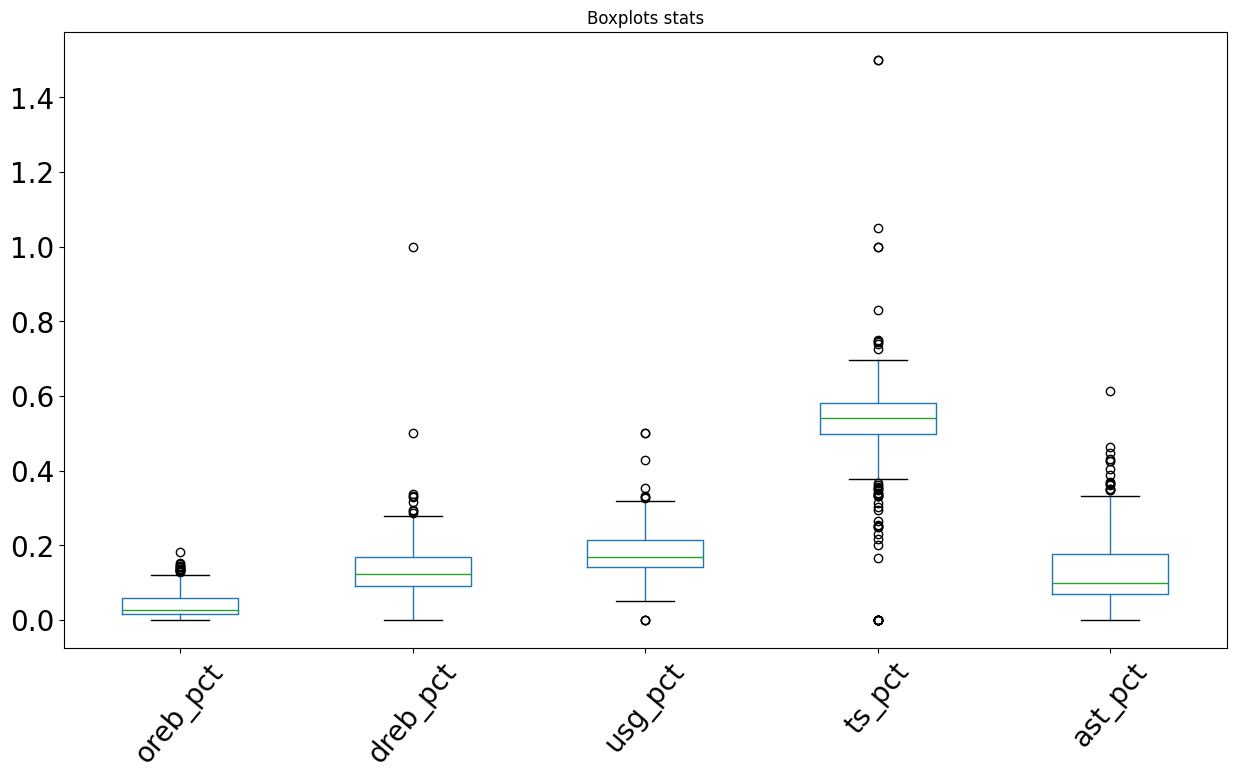

In [21]:
column_names = nba_2018.columns.tolist()
boxplot = column_names[3:-1] # No nos interesa graficar season
subset_data = nba_2018[boxplot]

plt.figure(figsize=(15, 8))
plt.title('Boxplots stats')
subset_data.boxplot(grid=False, rot=50, fontsize=20)
plt.show()

Al graficar los boxplots, podemos empezar a sacar algunas conclusiones interesantes. Para empezar, vemos que la variable objetivo, ts_pct, tiene mucha dispersión. Probablemente, esta venga relacionada con datos de jugadores que ese año jugaron muchos partidos y que tengan porcentajes desfasados. Jugadores con pocos tiros totales que generen outliers innecesarios. Algo parecido sucede con el net_rating y si nos fijamos, aunque en menor medida, sucede con la mayoría de las estadísticas.

Para corroborar esta información, podríamos usar la estadística de partidos jugados, pero creo que sería muchísimo más útil tener la información sobre los minutos por partido de estos jugadores e incluso, la situación de los partidos en esos minutos jugados. En la NBA, muchos partidos se decantan antes de llegar al 3.er cuarto y eso hace que los entrenadores vacíen sus banquillos y hagan jugar a jugadores reservas que normalmente no tendrían ninguna oportunidad. En estas ocasiones, las estadísticas se maquillan en exceso y generan alteraciones indebidas.

<Figure size 2000x1000 with 0 Axes>

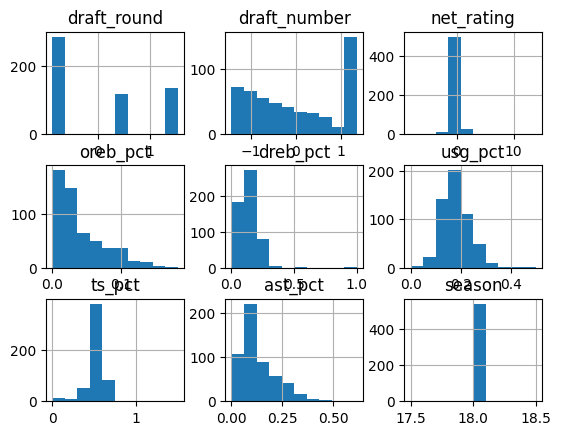

In [22]:
nba_2018_hist = nba_2018
plt.figure(figsize = (20,10))
nba_2018_hist.hist()
plt.show()

Con los histogramas vemos que la única variable que podría acercarse, por su forma, a una distribución normal es la variable de usg_pct, muchas de las demás estan sesgadas hacía la derecha.

c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigne

<Figure size 500x2000 with 0 Axes>

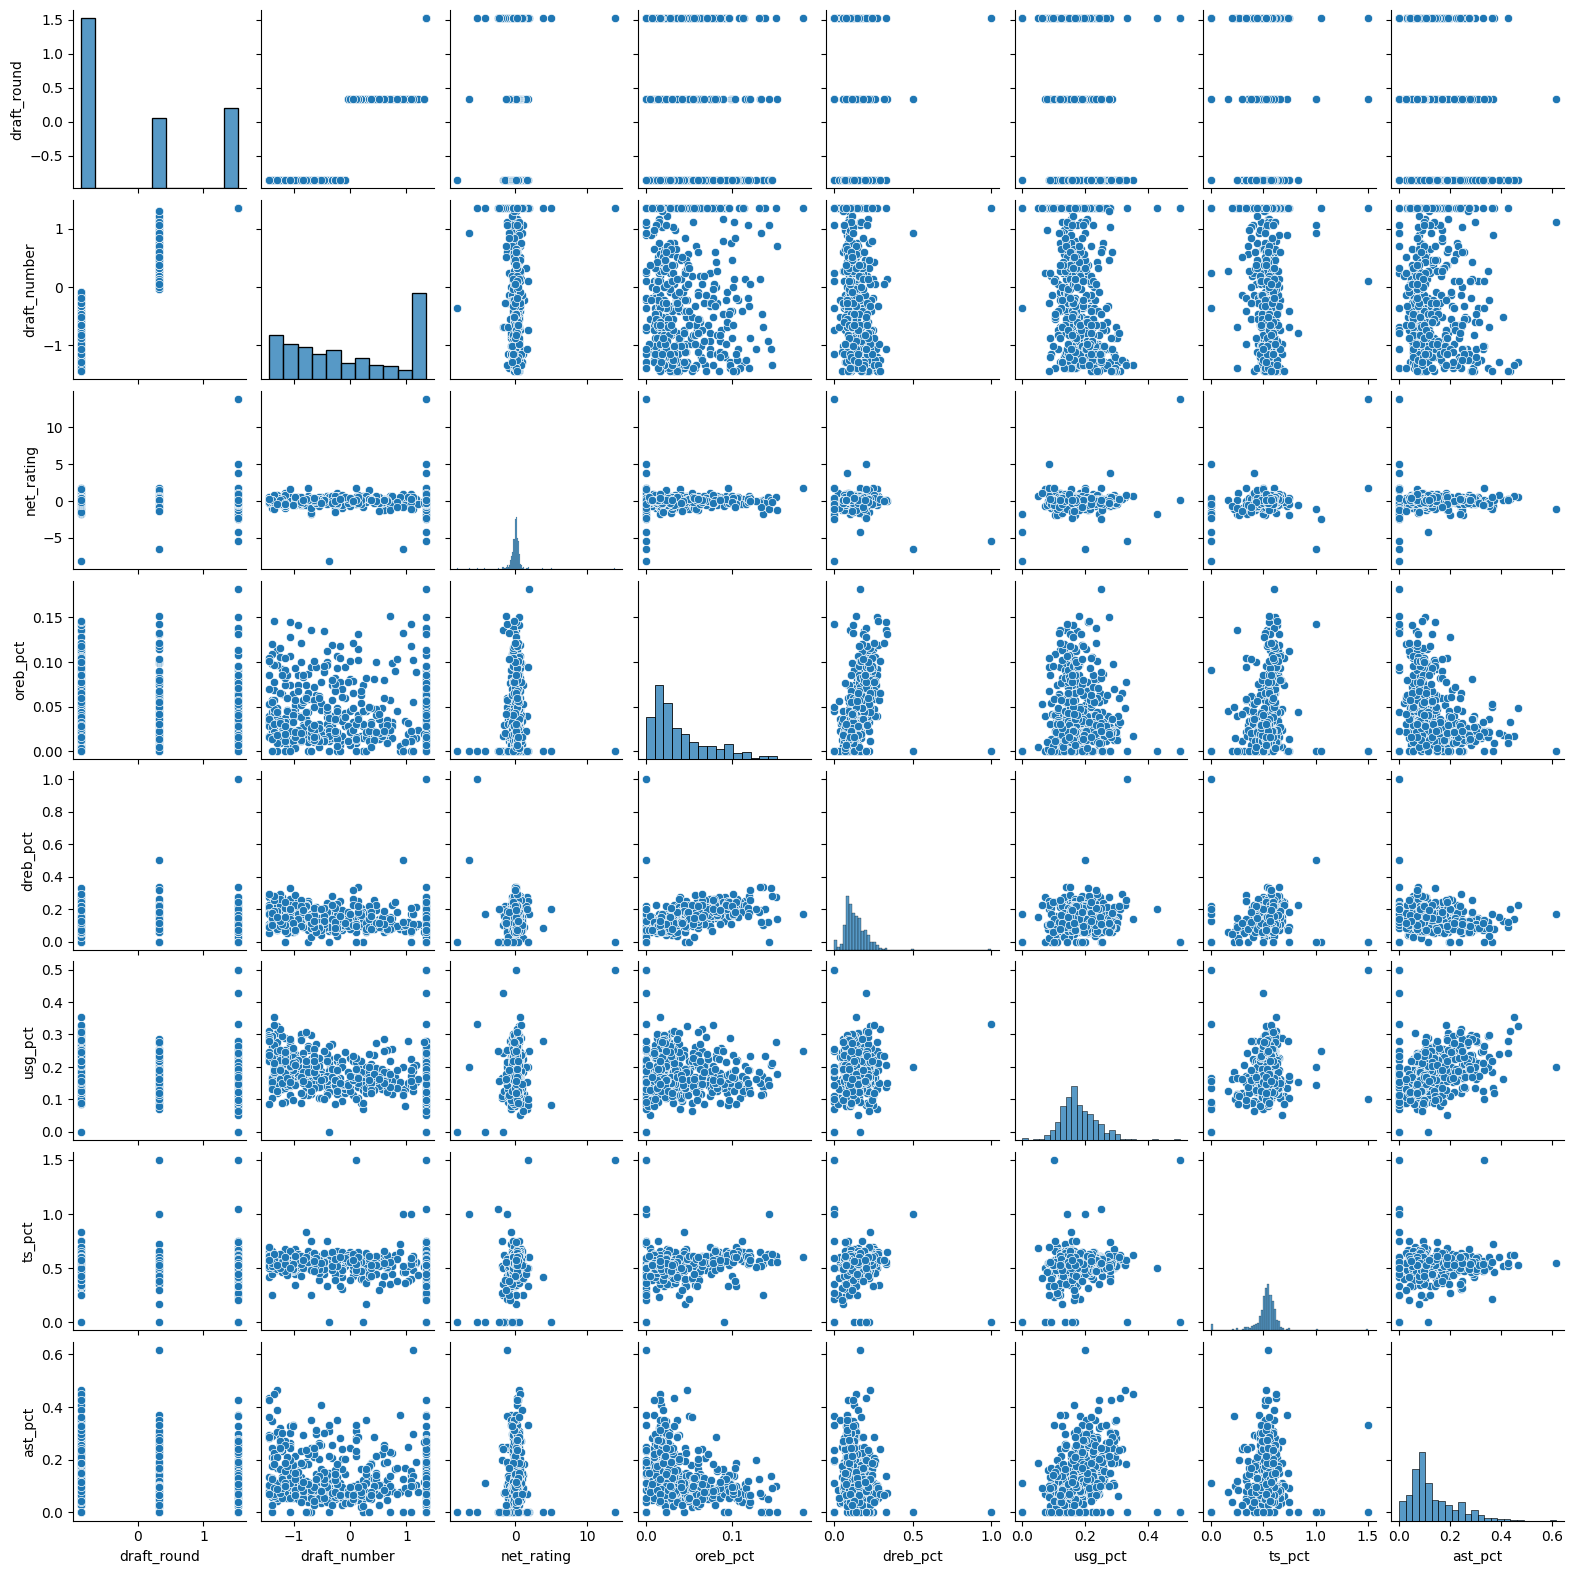

In [23]:
nba_2018_pct1 = nba_2018[['draft_round', 'draft_number', 'net_rating',
                         'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']]

# Pairplot using seaborn package
plt.figure(figsize=(5, 20))
sns.pairplot(nba_2018_pct1, height=2, palette="tab10")

plt.show()


Por último, y antes de empezar con la creación de los modelos, hemos querido hacer una previa con este pairplot. En él, vemos la relación de las variables entre ellas y su comportamiento al relacionarse. La idea era ver si ya con este gráfico podíamos empezar a ver algo de separabilidad entre nuestras variables, ver si se forman grupos o nubes de puntos, en los cuales deberíamos empezar a fijarnos de cara a los modelos.

Por desgracia, no parece ser así, los únicos puntos que se separan son los que están relacionados con el draft, pero esta es una separación artificial que nada tiene que ver con lo que estamos buscando.

In [24]:
nba_2018_pct = nba_2018[['oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']]


Antes de empezar a modelar, he decido hacer una última transformación de nuestros datos. Después de ver este pariplot, me he dado cuenta de que igual al introducir los datos del draft igual estabamos facilitandole al modelo una separación o clusterización de los datos forzada por el simple hecho de haber sido elejidos en una posición más alta o más baja del draft.

Aunque inicialmente creía que esto podía ser una buena idea, y por eso he gastado tiempo en transformar y normalizar estos datos, después de esta reflexión, también he iniciado mi modelo con los datos incluidos y, efectivamente, empeoraban la mayoría de los modelos, así que he decidido eliminar estos datos.

Con el de net_rating he tenido muchas dudas, pero finalmente también he decidido dejarlo fuera, ya que al empezar los modelos con él, simplemente estos empeoraban y en parte creo que tiene poco que ver con las estadísticas que estamos mirando. De hecho, me he dado cuenta de que es un dato que viene muy afectado por el equipo y situación del jugador en cuestión.

De esta manera, solo nos quedarán datos de estadística avanzada de la nba. Con ellos buscaremos encontrar grupos de jugadores diferentes con base en sus características de juego y a su comportamiento en la pista. Creo que la 2018 es una buena temporada para hacer este análisis, pero realmente la idea es acabar usándolo para generar grupos con cantidades de datos mayores.

# Jerárquico

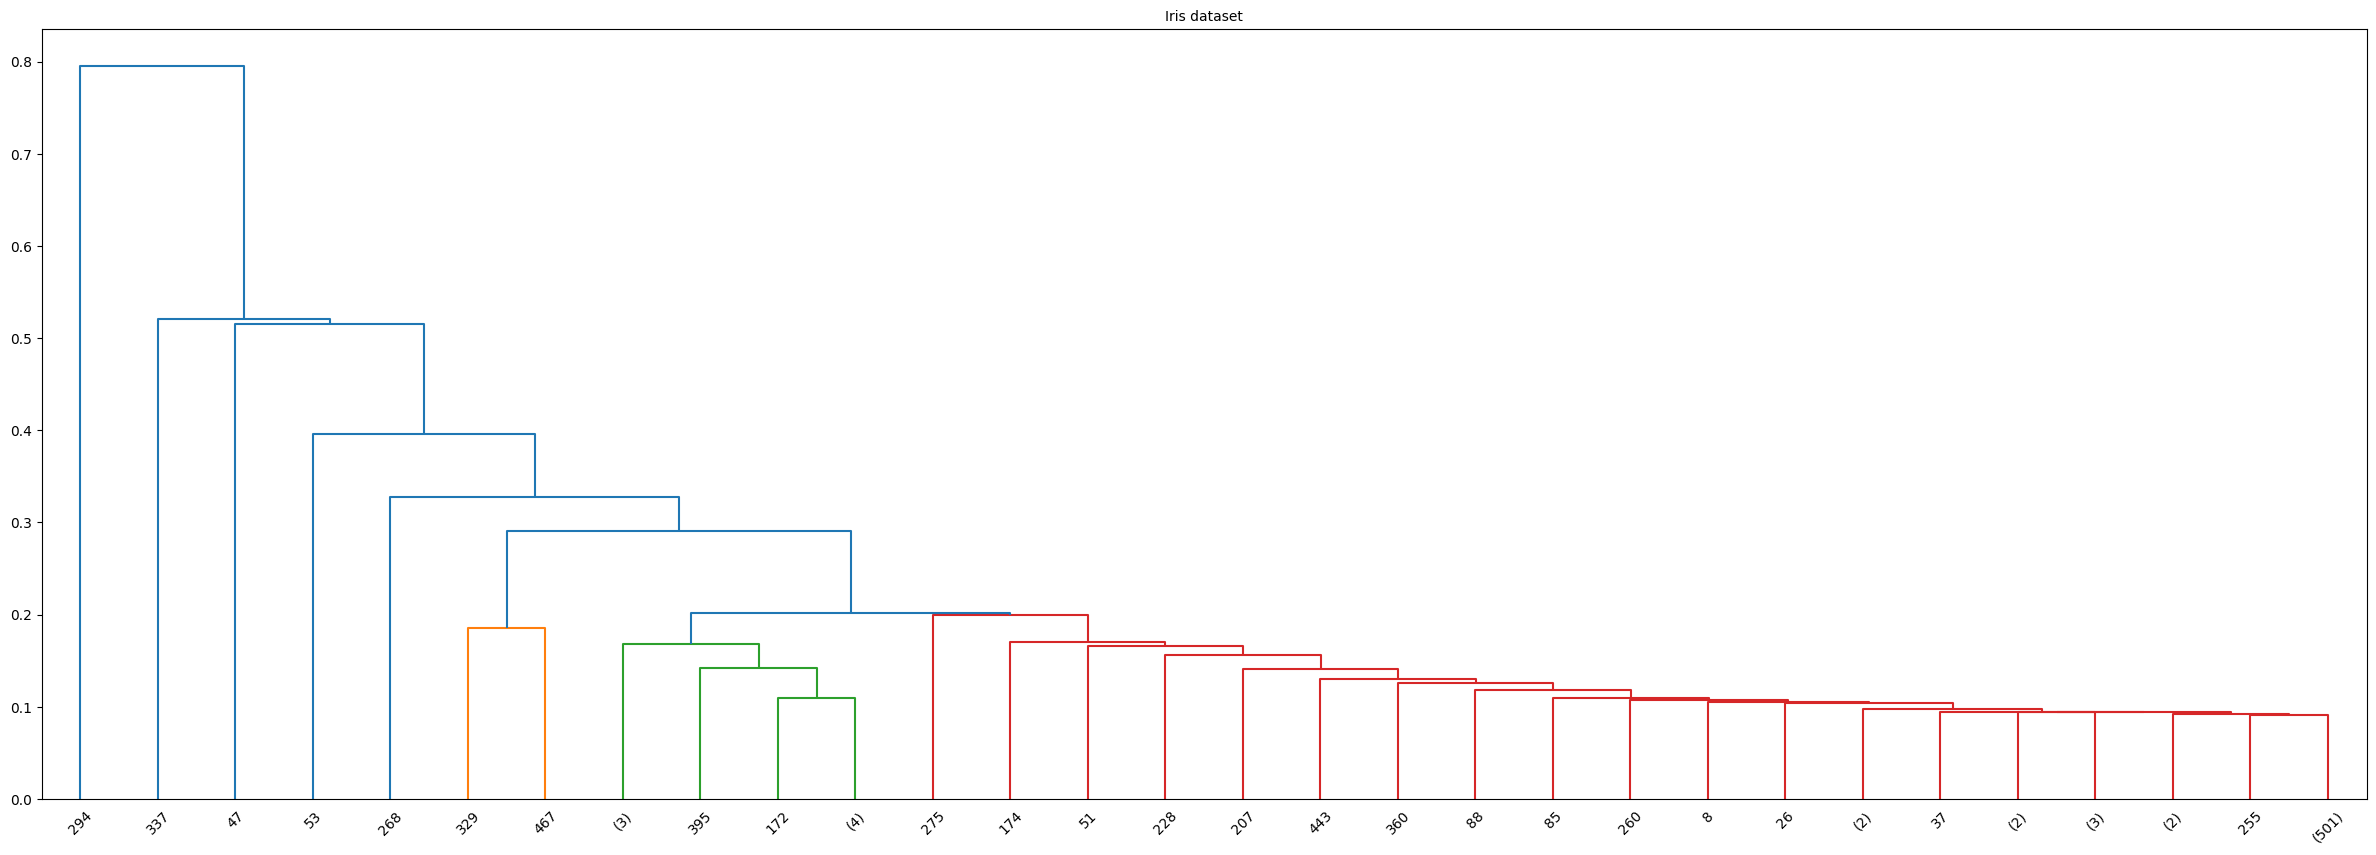

In [25]:
Z = hierarchy.linkage(nba_2018_pct)

plt.figure(figsize = (30, 10))

cLimit = 0.2

dn = hierarchy.dendrogram(Z, truncate_mode = 'lastp', color_threshold = cLimit, count_sort = "ascending")
plt.title("Iris dataset", fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

El modelo jerárquico es un método de clusterización que, básicamente crea una jerarquía de clusters. La mejor representación posibel es este dendograma que tenemos encima, donde podemos ver como nuestros datos se agrupan y como los clústeres se forman entre si. Notése que tenemos 3 clusters bien diferenciados pero con un tamaño muy distinto de datos.

Para el funcionamiento de este modelo, necesitamos marcar nosotros un límite de corte que será el punto en el cual nosotros dividiremos la jerarquía y empezaremos a crear clústeres distintos. Yo he usado 0,2 como línea de corte, esta elección es completamente subjetiva, pero a mí me ha parecido que es lo más cercano a lo que debería salir de mis modelos, tres tipos de jugadores:
- Pívots o ala-pívots con eficiencia en el tiro, pocas asistencias y muchos rebotes
- Aleros con valores medianos en la mayoría de las estadísticas
- Bases y escoltas, mayormente asistentes y con bajos números en rebotes

También merece la pena comentar que hay una serie de observaciones (las de la derecha del gráfico) que el modelo no las está agrupando en ningún clúster.

In [26]:
clustering1 = AgglomerativeClustering(n_clusters=3).fit(nba_2018_pct)


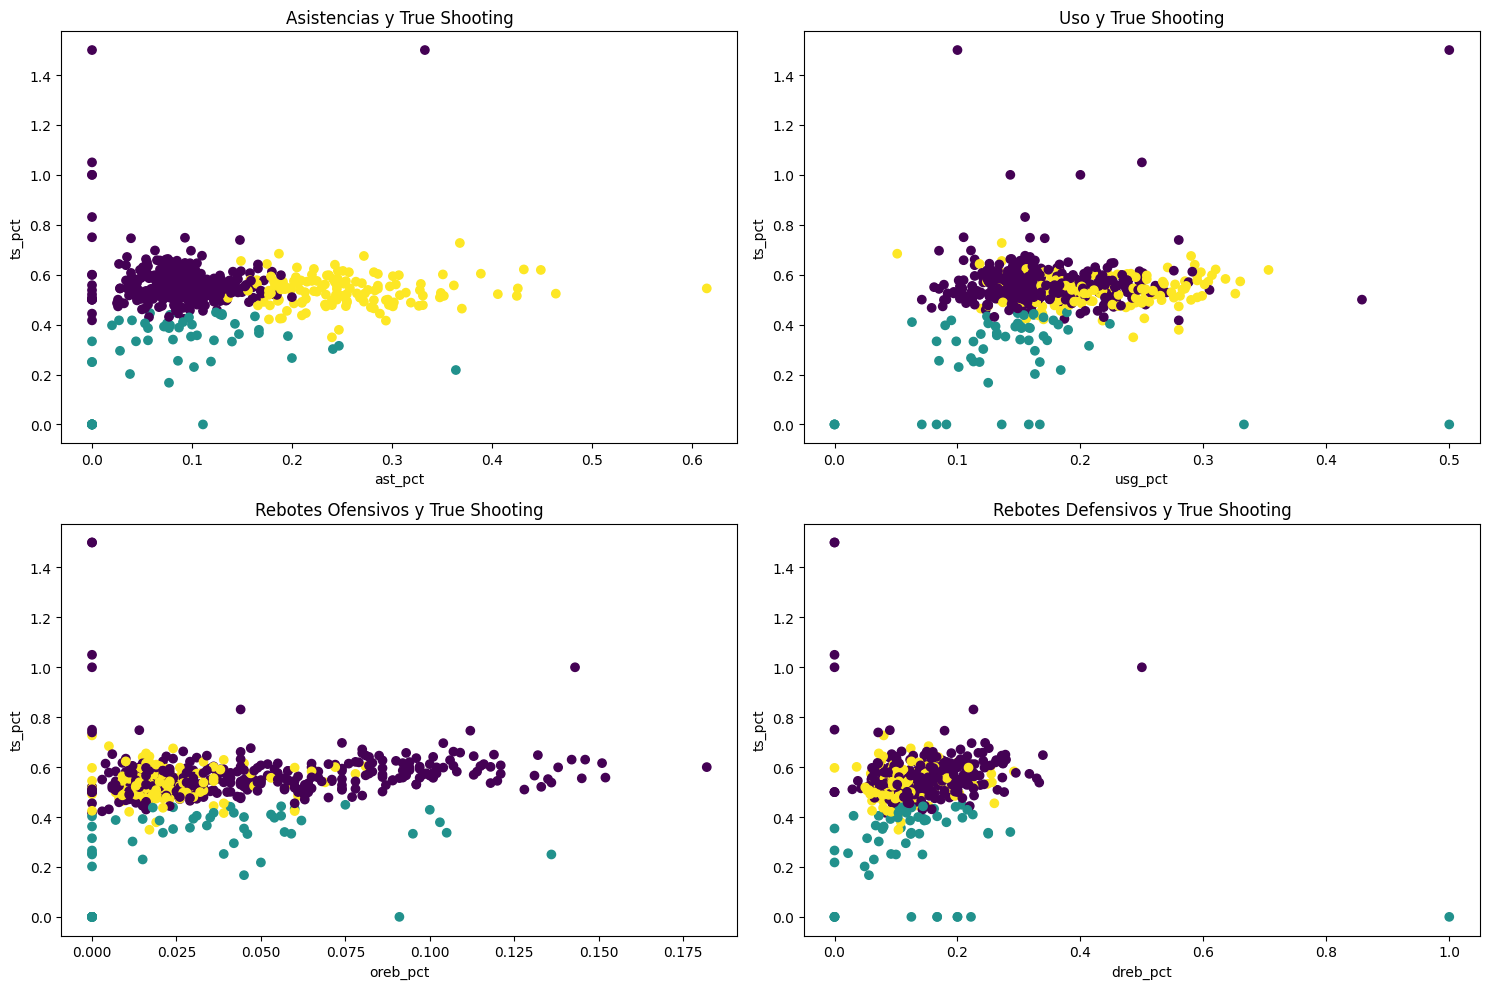

In [27]:
# Primero he graficado los resultados del modelos cruzado todas las variables con la variable objetivo

# Clustering 1
x1 = nba_2018_pct['ast_pct']
y1 = nba_2018_pct['ts_pct']

# Clustering 2
x2 = nba_2018_pct['usg_pct']
y2 = nba_2018_pct['ts_pct']

# Clustering 3
x3 = nba_2018_pct['oreb_pct']
y3 = nba_2018_pct['ts_pct']

# Clustering 4
x4 = nba_2018_pct['dreb_pct']
y4 = nba_2018_pct['ts_pct']

# Create subplots with a 2x3 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot 1
axes[0, 0].scatter(x1, y1, c=clustering1.labels_, cmap='viridis')
axes[0, 0].set_title('Asistencias y True Shooting')
axes[0, 0].set_xlabel('ast_pct')
axes[0, 0].set_ylabel('ts_pct')

# Scatter plot 2
axes[0, 1].scatter(x2, y2, c=clustering1.labels_, cmap='viridis')
axes[0, 1].set_title('Uso y True Shooting')
axes[0, 1].set_xlabel('usg_pct')
axes[0, 1].set_ylabel('ts_pct')

# Scatter plot 3
axes[1, 0].scatter(x3, y3, c=clustering1.labels_, cmap='viridis')
axes[1, 0].set_title('Rebotes Ofensivos y True Shooting')
axes[1, 0].set_xlabel('oreb_pct')
axes[1, 0].set_ylabel('ts_pct')

# Scatter plot 4
axes[1, 1].scatter(x4, y4, c=clustering1.labels_, cmap='viridis')
axes[1, 1].set_title('Rebotes Defensivos y True Shooting')
axes[1, 1].set_xlabel('dreb_pct')
axes[1, 1].set_ylabel('ts_pct')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\Marc\AppData\Local\Temp\ipykernel_3312\516710212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairplot_data['labels'] = clustering1.labels_


<Figure size 1500x1500 with 0 Axes>

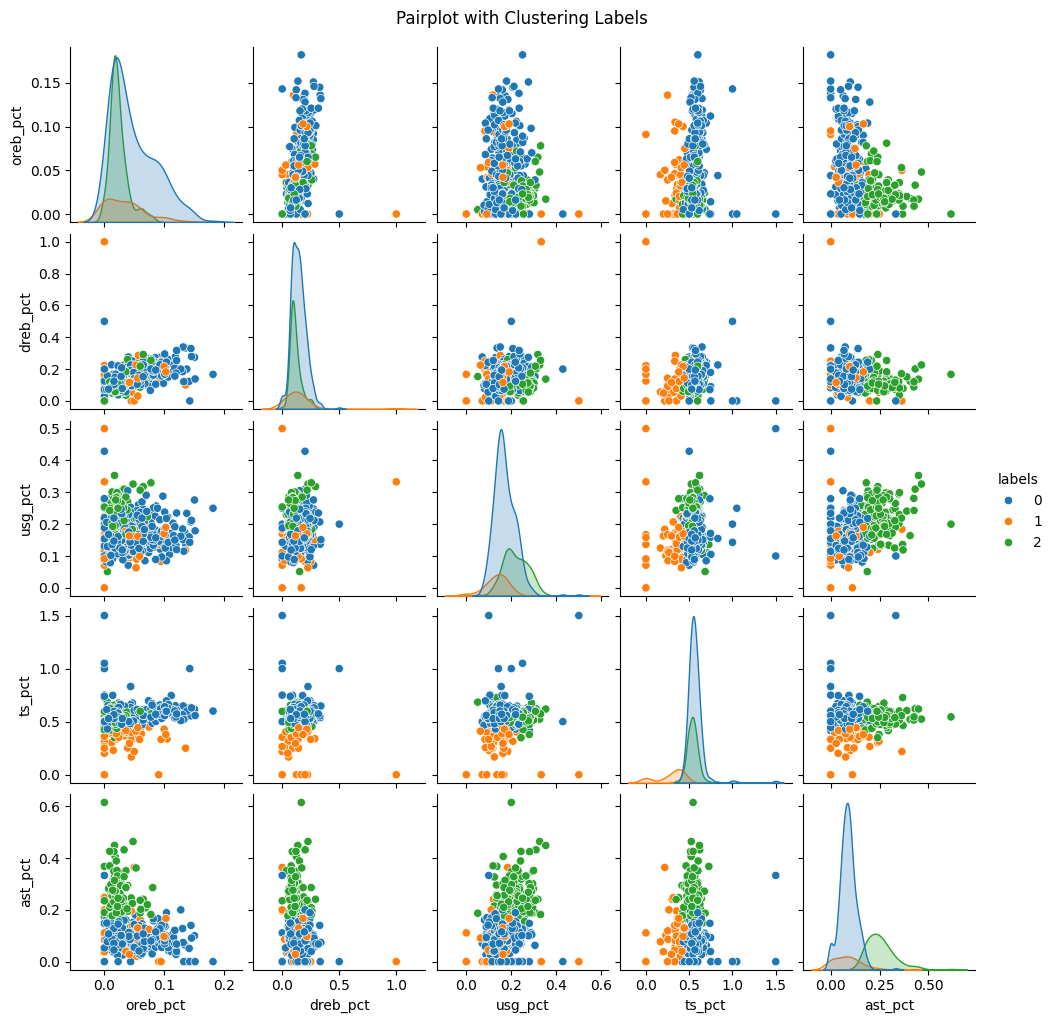

In [28]:
# Y aquí hemos graficado todos los posibles gráficos separando también por los tres clústers que nos propone el modelo

pairplot_data = nba_2018_pct
pairplot_data['labels'] = clustering1.labels_


plt.figure(figsize=(15, 15)) 
sns.pairplot(pairplot_data, height=2, palette='tab10', hue='labels')
plt.suptitle('Pairplot with Clustering Labels', y=1.02) 
plt.show()


A la hora de graficar, he decidido enfocarme primero en una serie de gráficos relacionando todas las variables con la variable objetivo. En estos, se ve algo de separabilidad, especialmente cuando relacionamos la variable ast_pct con el ts_pct, pero en las demás, la realidad es que cuesta ver separabilidad.

Por otro lado, he decidido volver a hacer un pairplot de todas las variables, pero esta vez pintando con las etiquetas creadas por el modelo. Se ve claramente que en muchas de las variables no hay ningún tipo de separabilidad y en algunas se intuyen más dos clúster que tres. Si nos fijamos en los gráficos de densidad de la diagonal de la matriz, podemos observar que solo en ts_pct y ast_pct hay al menos una variable que parece tener una distribución distinta.

**Silhouette Score:**

Como visualmente ha sido difícil de valorar la calidad de los clústeres creados he decidido buscar distintas métricas para valorar como funciona el modelo, sobre todo teniendo en cuenta que no tenemos etiquetas con las que comparar la calidad de este.

He encontrado que el coeficiente de silueta es una métrica que nos puede ayudar, ya que calcula la cohesión del clúster y su separación respecto a otros clústeres. Usando como principales datos en la fórmula la distanciad entre los puntos de un mismo clúster y la distancia de cada punto al clúster más cercano (que no sea el suyo).

El resultado varía entree -1 y 1 siendo 1 un modelo que se ajusta bien a su propio cluster pero que no lo hace con los demás clusteres y viceversa con los valores bajos.

La realidad es que el resultado del score me parece mucho más alto de lo que me esperaba inicialmente

In [29]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(nba_2018_pct, clustering1.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.8442889245828665


# K - Means

A continuación, vamos a intentar usar K-means para probar de encontrar un resultado algo mejor. Para ello, será necesario empezar escogiendo la cantidad de clústeres óptima usando el método del codo y, sabiendo esto, vamos a usar el algoritmo marcando nosotros la cantidad de clústeres que queremos y buscando el mejor modelo posible.

In [30]:
nba_2018_pct.head()

,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,labels
9561,0.030,0.152,0.265,0.539,0.104,0
9562,0.046,0.200,0.176,0.509,0.081,0
9563,0.040,0.173,0.194,0.566,0.107,0
9564,0.012,0.072,0.121,0.302,0.241,1
9565,0.074,0.245,0.111,0.697,0.063,0


In [31]:
nba_2018_kmeans = nba_2018_pct.drop('labels', axis=1)
nba_2018_kmeans.head()

,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
9561,0.030,0.152,0.265,0.539,0.104
9562,0.046,0.200,0.176,0.509,0.081
9563,0.040,0.173,0.194,0.566,0.107
9564,0.012,0.072,0.121,0.302,0.241
9565,0.074,0.245,0.111,0.697,0.063


In [32]:
from sklearn.model_selection import train_test_split

x_kmeans = nba_2018_kmeans
y_kmeans = nba_2018_kmeans

X_train, X_test, y_train, y_test = train_test_split(x_kmeans, y_kmeans, test_size=0.2, random_state=4)

print("Training Dataset:", X_train.shape)
print("Validation Dataset:", X_test.shape)


Training Dataset: (432, 5)
Validation Dataset: (108, 5)


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\

(1.0, 8.0, 0.0, 40.0)

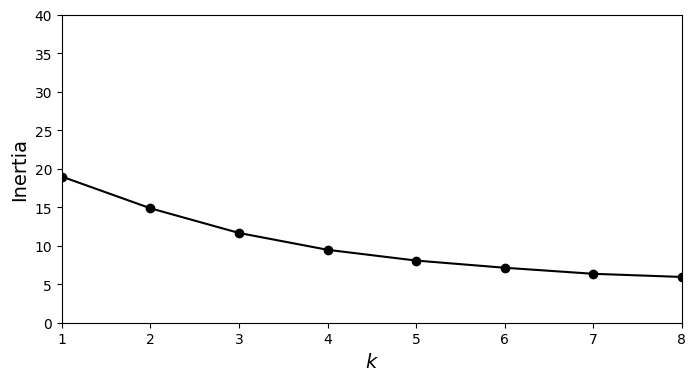

In [33]:
nba_kmeans1 = [KMeans(n_clusters=k, random_state=4).fit(x_kmeans) for k in range(1, 20)]

inertias = [model.inertia_ for model in nba_kmeans1]

plt.figure(figsize=(8, 4))

plt.plot(range(1, 20), inertias, 'ko-')

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.axis([1, 8, 0, 40])


La realidad es que el método del codo nos da unos resultados un poco ambiguos y difíciles de interpretar. Al ver estos resultados, lo que se debería hacer es intentar encontrar en que punto de X hay un cambio más importante en la pendiente de la línea negra, pero la realidad es que hay que fijarse mucho para poder llegar a una conclusión. Esta es una decisión que generalmente se toma a ojo y como yo no estoy seguro, he decidido que probaré el modelo para 3 y 4 clústeres.

In [34]:
nba_kmeans_3 = KMeans(n_clusters=3, random_state = 4).fit(x_kmeans)

# Etiquetas
kmeans_3_labels = nba_kmeans_3.predict(x_kmeans)

nba_2018_kmeans['labels_kmeans3'] = kmeans_3_labels

nba_2018_kmeans.head()


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,labels_kmeans3
9561,0.030,0.152,0.265,0.539,0.104,0
9562,0.046,0.200,0.176,0.509,0.081,0
9563,0.040,0.173,0.194,0.566,0.107,0
9564,0.012,0.072,0.121,0.302,0.241,1
9565,0.074,0.245,0.111,0.697,0.063,0


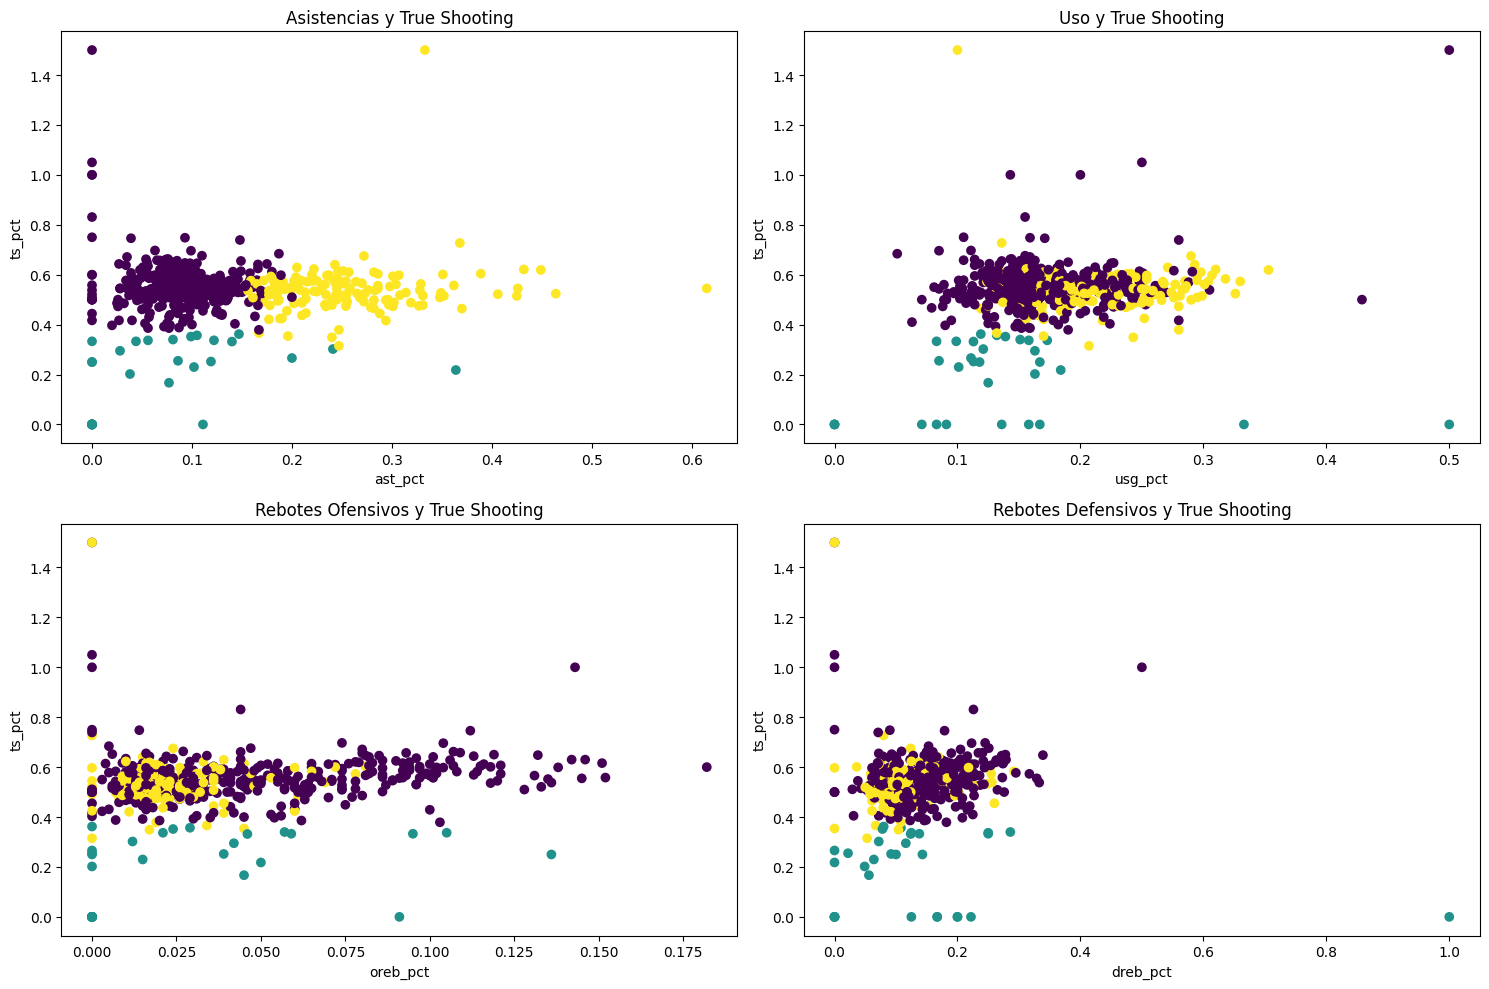

In [35]:
# Primero he graficado los resultados del modelos cruzado todas las variables con la variable objetivo

# Kmeans 1
x1 = nba_2018_kmeans['ast_pct']
y1 = nba_2018_kmeans['ts_pct']

# Kmeans 2
x2 = nba_2018_kmeans['usg_pct']
y2 = nba_2018_kmeans['ts_pct']

# Kmeans 3
x3 = nba_2018_kmeans['oreb_pct']
y3 = nba_2018_kmeans['ts_pct']

# Kmeans 4
x4 = nba_2018_kmeans['dreb_pct']
y4 = nba_2018_kmeans['ts_pct']

# Create subplots with a 2x3 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot 1
axes[0, 0].scatter(x1, y1, c=kmeans_3_labels, cmap='viridis')
axes[0, 0].set_title('Asistencias y True Shooting')
axes[0, 0].set_xlabel('ast_pct')
axes[0, 0].set_ylabel('ts_pct')

# Scatter plot 2
axes[0, 1].scatter(x2, y2, c=kmeans_3_labels, cmap='viridis')
axes[0, 1].set_title('Uso y True Shooting')
axes[0, 1].set_xlabel('usg_pct')
axes[0, 1].set_ylabel('ts_pct')

# Scatter plot 3
axes[1, 0].scatter(x3, y3, c=kmeans_3_labels, cmap='viridis')
axes[1, 0].set_title('Rebotes Ofensivos y True Shooting')
axes[1, 0].set_xlabel('oreb_pct')
axes[1, 0].set_ylabel('ts_pct')

# Scatter plot 4
axes[1, 1].scatter(x4, y4, c=kmeans_3_labels, cmap='viridis')
axes[1, 1].set_title('Rebotes Defensivos y True Shooting')
axes[1, 1].set_xlabel('dreb_pct')
axes[1, 1].set_ylabel('ts_pct')

# Adjust layout
plt.tight_layout()
plt.show()


In [36]:
silhouette_kmeans = silhouette_score(x_kmeans, kmeans_3_labels)
print(f"Silhouette Score: {silhouette_kmeans}")


Silhouette Score: 0.8482455875350864


In [37]:
# Modelo con 4 clústeres

nba_kmeans_4 = KMeans(n_clusters=4, random_state = 4).fit(x_kmeans)

# Etiquetas
kmeans_4_labels = nba_kmeans_4.predict(x_kmeans)

nba_2018_kmeans['labels_kmeans4'] = kmeans_4_labels

nba_2018_kmeans.head()


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,labels_kmeans3,labels_kmeans4
9561,0.030,0.152,0.265,0.539,0.104,0,3
9562,0.046,0.200,0.176,0.509,0.081,0,3
9563,0.040,0.173,0.194,0.566,0.107,0,0
9564,0.012,0.072,0.121,0.302,0.241,1,2
9565,0.074,0.245,0.111,0.697,0.063,0,0


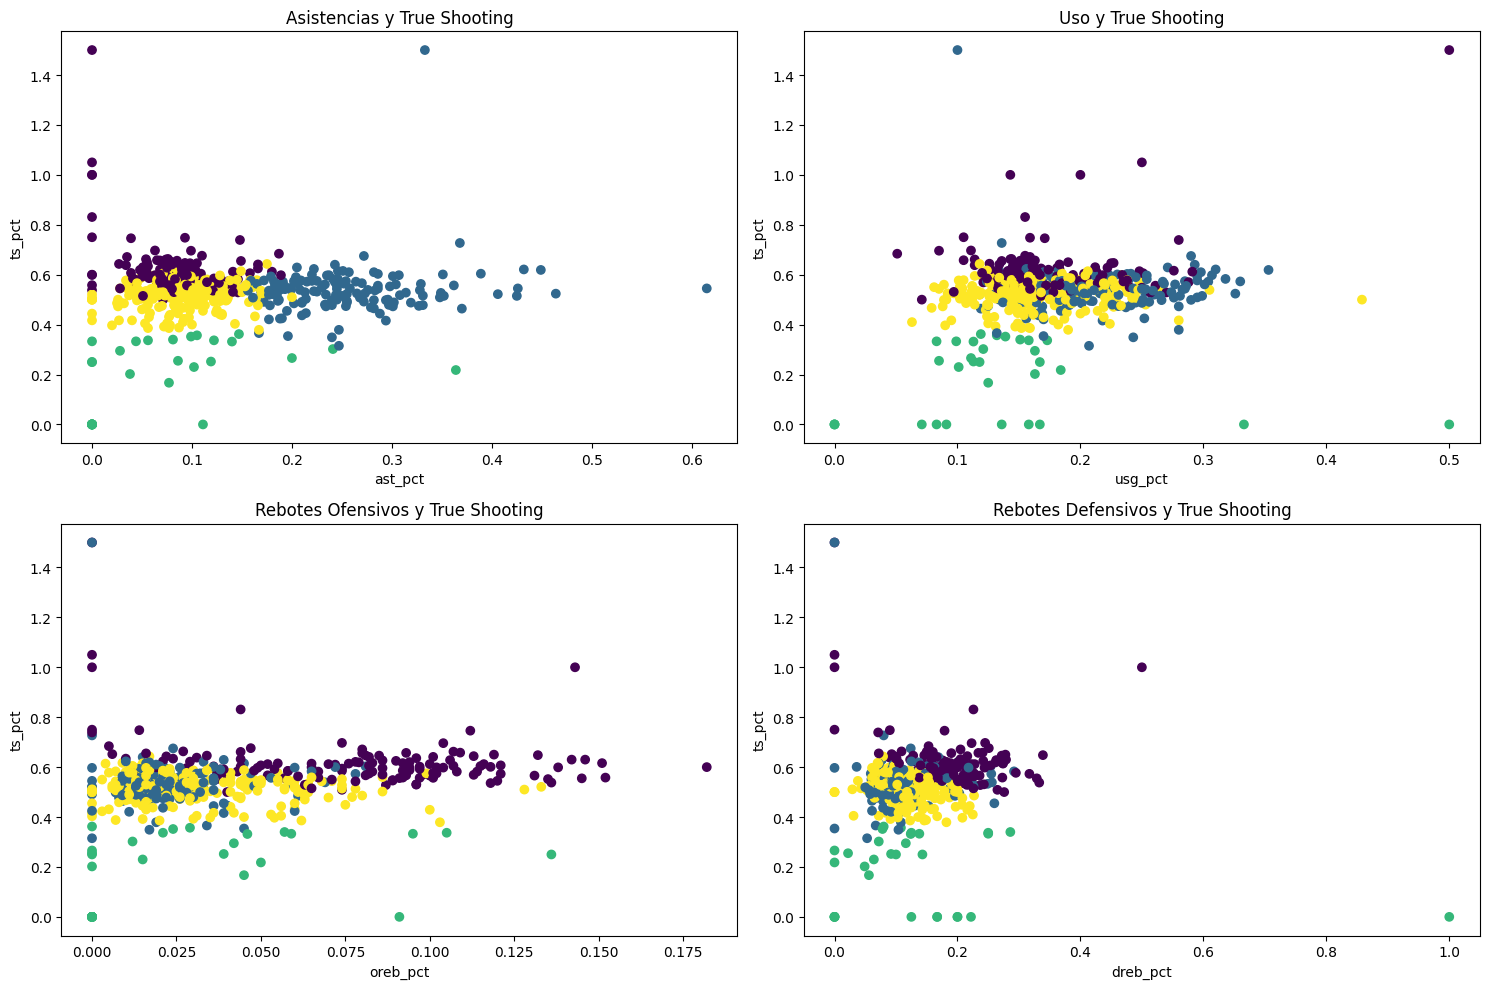

In [38]:
# Kmeans 1
x1 = nba_2018_kmeans['ast_pct']
y1 = nba_2018_kmeans['ts_pct']

# Kmeans 2
x2 = nba_2018_kmeans['usg_pct']
y2 = nba_2018_kmeans['ts_pct']

# Kmeans 3
x3 = nba_2018_kmeans['oreb_pct']
y3 = nba_2018_kmeans['ts_pct']

# Kmeans 4
x4 = nba_2018_kmeans['dreb_pct']
y4 = nba_2018_kmeans['ts_pct']

# Create subplots with a 2x3 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot 1
axes[0, 0].scatter(x1, y1, c=kmeans_4_labels, cmap='viridis')
axes[0, 0].set_title('Asistencias y True Shooting')
axes[0, 0].set_xlabel('ast_pct')
axes[0, 0].set_ylabel('ts_pct')

# Scatter plot 2
axes[0, 1].scatter(x2, y2, c=kmeans_4_labels, cmap='viridis')
axes[0, 1].set_title('Uso y True Shooting')
axes[0, 1].set_xlabel('usg_pct')
axes[0, 1].set_ylabel('ts_pct')

# Scatter plot 3
axes[1, 0].scatter(x3, y3, c=kmeans_4_labels, cmap='viridis')
axes[1, 0].set_title('Rebotes Ofensivos y True Shooting')
axes[1, 0].set_xlabel('oreb_pct')
axes[1, 0].set_ylabel('ts_pct')

# Scatter plot 4
axes[1, 1].scatter(x4, y4, c=kmeans_4_labels, cmap='viridis')
axes[1, 1].set_title('Rebotes Defensivos y True Shooting')
axes[1, 1].set_xlabel('dreb_pct')
axes[1, 1].set_ylabel('ts_pct')

# Adjust layout
plt.tight_layout()
plt.show()


In [39]:
silhouette_kmeans4 = silhouette_score(x_kmeans, kmeans_4_labels)
print(f"Silhouette Score: {silhouette_kmeans4}")


Silhouette Score: 0.9059100945243743


Una vez vistos los dos modelos, analizados gráficamente y calculador el Silhouette Score, parece ser que el modelo de 4 clústeres es un pelín mejor. El score da un resultado superior, pero es que en la prueba visual también parece haber un poco más de claridad o separabilidad, no en exceso, porque no parece un modelo perfecto.

Como veíamos anteriormente en el modelo jerárquico, las dos variables que parecen las mejores a la hora de graficar y explicar lo que está sucediendo son la variable objetivo, ts_pct, y la variable ast_pct

Un punto importante que me hubiera gustado añadir aquí y que la realidad es que no he tenido tiempo de hacer es aplicar estos modelos a cantidades de datos más grandes. Probablemente, hubiera merecido la pena ver como impactaba esta separación que nos han creado en datos de los últimos 5 o 10 años.

# DBSCAN

In [40]:
nba_dbscan1 = nba_2018_pct.drop('labels', axis=1)

nba_dbscan1.head()


,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
9561,0.030,0.152,0.265,0.539,0.104
9562,0.046,0.200,0.176,0.509,0.081
9563,0.040,0.173,0.194,0.566,0.107
9564,0.012,0.072,0.121,0.302,0.241
9565,0.074,0.245,0.111,0.697,0.063


In [41]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.2 ,min_samples = 2).fit(nba_dbscan1)
dbscan_labels = dbscan.labels_

n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) 
n_noise_ = list(dbscan_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 3
Estimated number of noise points: 5


In [42]:
nba_dbscan1['labels_dbscan'] = dbscan_labels
nba_dbscan1.head()

,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,labels_dbscan
9561,0.030,0.152,0.265,0.539,0.104,0
9562,0.046,0.200,0.176,0.509,0.081,0
9563,0.040,0.173,0.194,0.566,0.107,0
9564,0.012,0.072,0.121,0.302,0.241,0
9565,0.074,0.245,0.111,0.697,0.063,0


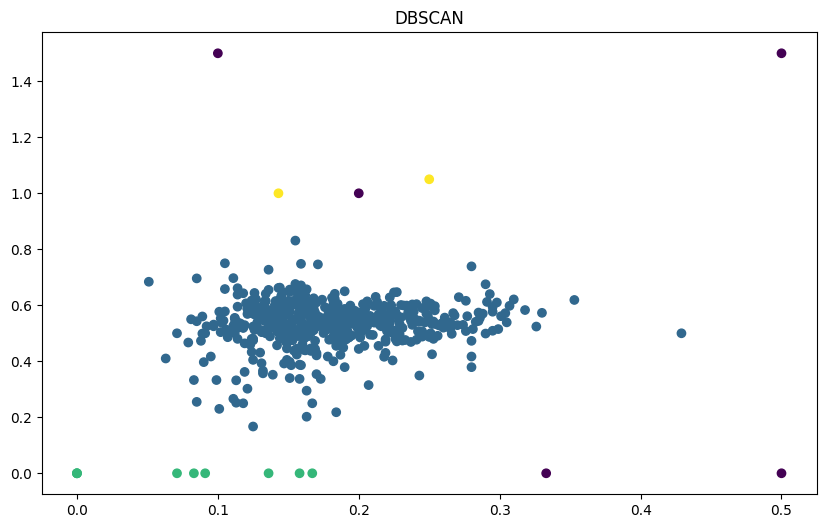

In [43]:
plt.figure(figsize = (10, 6))
plt.scatter(nba_dbscan1.usg_pct, nba_dbscan1.ts_pct, c = nba_dbscan1.labels_dbscan)
plt.title("DBSCAN")
plt.show()

La realidad para el DBSCAN es que después de haber probado de ajustar los valores tanto de distancias y muestras mínimas para obtener un número de clúster similar al que nos daban los demás modelos, el resultado ha sido bastante malo.

El número de observaciones consideradas ruido es relativamente bajo, pero pese a ello, cuando graficamos nos damos cuenta de que pese a que dice observar 3 clústeres distintos, el resultado es un único clúster muy grande y pequeñas observaciones sueltas que valora como dos clústeres más pequeños, muy pequeños.

# Conclusiones

Una vez planteados y observados los resultados de los modelos, parece difícil poder decir que ninguno de ellos presenta unos resultados perfectos, pero sí que creo que existen diferencias evidentes entre ellos.

Para empezar, probablemente el modelo que peor cree los clústeres parece ser el modelo DBSCAN, ya que con la prueba visual nos damos cuenta de que de lo que comentábamos anteriormente, hemos tenido que forzarlo en exceso para crear tres clústeres distintos que al graficarlo no lo parecen ser. También me gustaría añadir aquí que probé de visualizar como quedaría este mismo modelo con los datos desde 2018 hasta la actualidad (creyendo que igual encontrábamos algo más óptimo, pero la realidad es que los resultados empeoraban y decidí eliminarlo para mantener la coherencia a lo largo del trabajo).

Por otro lado, en cuanto a los dos modelos que hemos probado con el K-means y el modelo jerárquico, parecen obtener resultados parecidos. La realidad es que seguimos viendo poca separabilidad entre los datos, pero sí que hemos encontrado un poco más de estabilidad en la clusterización en los tres modelos. Seguramente, si se tuviera que elegir uno de los tres, escogería el modelo K-means con 4 clústeres. Para empezar porque el resultado del Silhouette-Score es el más alto, pero también porque con la prueba visual es el que parece tener más sentido.

Por último, me gustaría comentar que pese a que la teoría nos dice que el modelo con unos costos computacionales más altos debería ser el jerárquico, no le he prestado demasiada atención a este tema por el hecho de haber reducido muchísimo el tamaño de los datos. Al trabajar con una cantidad de datos relativamente pequeña, creí que esto en ningún caso iba a ser un problema para el desarrollo de mi trabajo. Si bien es cierto que sí que lo podría llegar a ser para algunas de las propuestas de mejora que voy a mencionar a continuación. (Merece la pena decir que inicialmente sí que empezó siendo un problema el tiempo de cómputo porque, equivocándome, empecé planteando el modelo jerárquico con absolutamente todos los datos del data set, y claro, tardaba entre 3 y 4 minutos).

# Mejoras

Probablemente, este trabajo tenga muchos puntos de mejora, pero conforme avanzaba, yo mismo me he dado cuenta de que hay algunos que deberían ser prioritarios y que ayudarían a cerrar un análisis mejor, análisis y resultado de los modelos de clusterización.

La primera de ellas es el trato de los outliers, por falta de tiempo sobre todo, y por un poco de desconocimiento de como hacerlo, me dio miedo empezar a eliminar datos, ya que pensaba que como más información mejor, pero sí que creo que, en general, es una base de datos con muchos jugadores sobrantes. Como he mencionado al inicio, la NBA tiene muchos jugadores que juegan poco o que juegan partidos intrascendentes y creo que habría que haber encontrado la manera de eliminar estos jugadores que simplemente creo que han añadido ruido a los modelos. Seguramente la mejor opción para ello era eliminar a los jugadores que no llegarán a un número de partidos, pero no sabía si era la manera más precisa de hacerlo, sobre todo contando que hay jugadores muy buenos que pueden lesionarse una temporada y perderse grades temporadas de partidos, esos no son los que queremos eliminar, sino los que juegan muy poco y tiene métricas disparadas.

Por otro lado, el objetivo final tenía ser usar los datos de posición de cada jugador (los encontré en otro data set de kaggle) y usarlos como etiquetas para probar de ver si la división que estábamos haciendo entre los jugadores iba ligada con las distintas posiciones de este deporte. En definitiva, quería intentar estudiar los datos de cada uno de los clústeres creados para entender como estábamos separando, y una de las ideas para intentar entender esto era comparar con las posiciones de pista.

Por último, una cosa que la realidad no he podido hacer por falta de tiempo, pero que me hubiera gustado para tener más información, es ir amplificando el tamaño de la muestra seleccionada para ver el comportamiento del modelo creado con más temporadas. La realidad es que con el poco tiempo que he acabado teniendo al final y el desconocimiento de como hacerlo, me he quedado con las ganas de probarlo, pero creo que hubiera sido bastante interesante de cara a entender mejor como funcionaban estos tres algoritmos.